<h1 align=center><font size = 5>Feature map hook </h1 >


<h3>Objective for this Notebook</h3>
<h5> 1. 了解register_forward_hook如何操作</h5>

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
model = models.resnet50(pretrained=True)
model.eval()  # 推論模式，不更新權重


C:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tony1\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
features = []  # 用來儲存 hook 抓到的輸出

def hook_fn(module, input, output):
    features.append(output.detach())  # 使用 detach() 斷開與計算圖的連結


In [4]:
hook_handle = model.layer1[0].conv1.register_forward_hook(hook_fn)


In [5]:
# 圖片轉換流程（與 ResNet 預訓練要求一致）
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 載入圖片
image = Image.open("image.jpg").convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # 加上 batch 維度


In [6]:
with torch.no_grad():
    output = model(input_tensor)

# 檢查 feature shape
print("抓到的中間層特徵圖 shape:", features[0].shape)


抓到的中間層特徵圖 shape: torch.Size([1, 64, 56, 56])


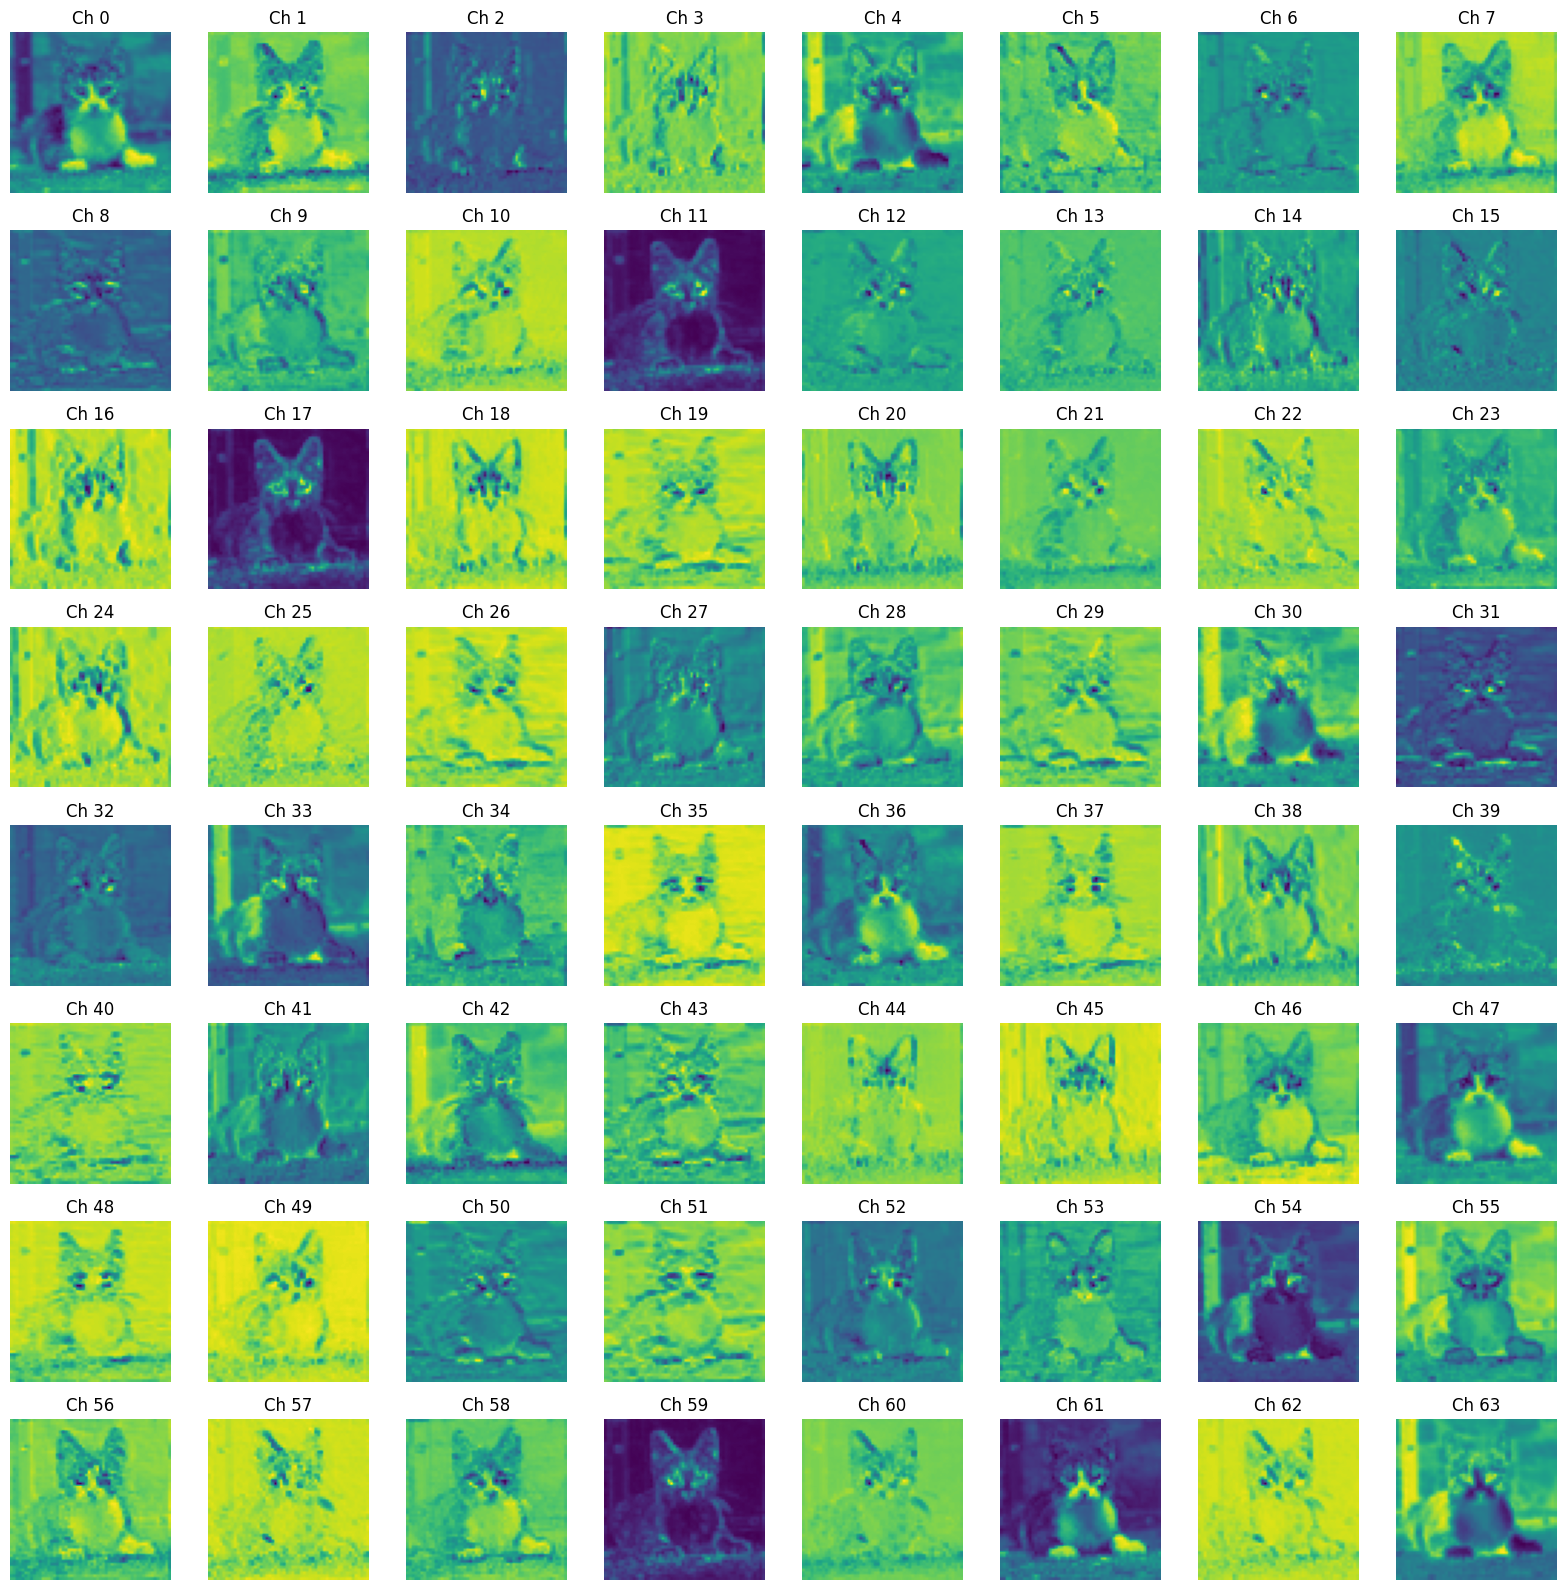

In [9]:
import math

# 取出特徵圖（shape: [batch, channel, H, W]）
feature_map = features[0][0]  # 取出 batch 中第0張圖的所有channel
num_channels = feature_map.shape[0]

# 計算要排列的 grid 尺寸
cols = 8
rows = math.ceil(num_channels / cols)

# 建立畫布
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

for i in range(rows * cols):
    if i < num_channels:
        ax = axes[i // cols, i % cols]
        ax.imshow(feature_map[i].cpu(), cmap='viridis')
        ax.set_title(f'Ch {i}')
        ax.axis('off')
    else:
        # 超出 channel 數時，隱藏多餘子圖格
        axes[i // cols, i % cols].axis('off')

plt.tight_layout()
plt.show()


In [8]:
hook_handle.remove()